In [2]:
import pandas as pd
import os

In [3]:
data_url = "/Users/benjaminzaidel/Desktop/Kaggle/Forex_Pairs"

In [5]:
import os
import pandas as pd

def create_wide_dataframe(data_folder: str, limit_rows: int = None) -> pd.DataFrame:
    """
    Reads all .txt files in `data_folder`, each containing
    <DTYYYYMMDD>, <TIME>, <CLOSE>, etc. The resulting DataFrame
    has:
      - A 'time_step' column (int) formed by concatenating date/time (YYYYMMDDHHMMSS).
      - One column per currency pair (derived from filename).
      - Each cell is the <CLOSE> value for that (time_step, currency_pair).
    
    Only reads up to `limit_rows` from each file (if provided).

    Then sorts rows by the first 8 digits of time_step (date),
    and then by the remaining digits (time).
    """

    dfs_for_merge = []

    for filename in os.listdir(data_folder):
        if filename.endswith(".txt"):
            filepath = os.path.join(data_folder, filename)
            
            # 1) Optionally limit rows
            if limit_rows is not None:
                df = pd.read_csv(filepath, nrows=limit_rows)
            else:
                df = pd.read_csv(filepath)

            required_cols = {"<DTYYYYMMDD>", "<TIME>", "<CLOSE>"}
            if not required_cols.issubset(df.columns):
                print(f"Warning: Missing required columns in '{filename}'. Skipping.")
                continue

            df["time_step"] = (
                df["<DTYYYYMMDD>"].astype(str) + df["<TIME>"].astype(str)
            ).astype(int)
            
            currency_pair = os.path.splitext(filename)[0]  # e.g. 'AUDJPY.txt' -> 'AUDJPY'

            mini_df = df[["time_step", "<CLOSE>"]].copy()
            mini_df.rename(columns={"<CLOSE>": currency_pair}, inplace=True)
            mini_df.set_index("time_step", inplace=True)

            dfs_for_merge.append(mini_df)

    if not dfs_for_merge:
        print("No valid data found or missing required columns.")
        return pd.DataFrame(columns=["time_step"])

    # 2) Merge all mini DataFrames side-by-side on time_step
    df_wide = pd.concat(dfs_for_merge, axis=1)

    df_wide.reset_index(inplace=True)

    # 3) Sort by date/time
    time_str = df_wide["time_step"].astype(str)
    date_part = time_str.str[:8].astype(int)
    time_part = time_str.str[8:].astype(int)

    df_wide["date_part"] = date_part
    df_wide["time_part"] = time_part

    df_wide.sort_values(by=["date_part", "time_part"], inplace=True, ascending=[True, True])
    df_wide.drop(["date_part", "time_part"], axis=1, inplace=True)

    return df_wide


In [6]:
from typing import List, Tuple
import numpy as np
def build_rate_matrices(df_wide: pd.DataFrame) -> Tuple[List[np.ndarray], List[int]]:
    """
    Convert each row of the wide df into an adjacency matrix.
    Returns a list of matrices (one per row) and
    the corresponding list of time_steps for reference.
    """
    # 1) Identify all currency pairs
    all_pairs = [col for col in df_wide.columns if col != "time_step"]
    
    # 2) Extract unique currencies
    currency_set = set()
    for pair in all_pairs:
        base = pair[:3]
        quote = pair[3:]
        currency_set.add(base)
        currency_set.add(quote)
    currency_list = sorted(list(currency_set))
    currency_to_idx = {cur: i for i, cur in enumerate(currency_list)}
    
    # 3) We'll build a list of adjacency matrices, one per row
    rate_matrices = []
    time_steps = []

    for _, row in df_wide.iterrows():
        # Initialize adjacency
        n_c = len(currency_list)
        mat = np.zeros((n_c, n_c), dtype=np.float32)
        # set diagonal to 1.0
        np.fill_diagonal(mat, 1.0)
        
        for pair in all_pairs:
            rate = row[pair]
            if pd.isna(rate):
                continue
            base = pair[:3]
            quote = pair[3:]
            
            i = currency_to_idx[base]
            j = currency_to_idx[quote]
            
            mat[i, j] = rate
            
            # if you also want to fill the reciprocal:
            if rate > 0:
                mat[i, j] = rate
                mat[j, i] = 1 / rate
            else:
                mat[i, j] = 0
                mat[j, i] = 0

        
        
        rate_matrices.append(mat)
        time_steps.append(row["time_step"])
    
    return rate_matrices, time_steps, currency_list


Summary of Potential Improvements
Partial trades reduce the risk of catastrophic all‐in moves.
Reward capping or rescaling can prevent extremely negative outcomes from dominating training.
Risk metrics or stop‐loss logic can help the agent learn to avoid large drawdowns.
Transaction costs can also mitigate over‐trading, which might lead to fewer big negative moves.

In [7]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces

class ForexTradingEnv(gym.Env):
    def __init__(self, rate_matrices, currency_list, base_currency='USD',
                 max_steps_per_episode=1000):
        super().__init__()
        
        self.rate_matrices = rate_matrices
        self.currency_list = currency_list
        self.n_c = len(currency_list)
        self.base_idx = currency_list.index(base_currency)
        
        self.num_steps = len(rate_matrices)
        self.max_steps_per_episode = max_steps_per_episode
        
        # Portfolio: track how much of each currency we hold
        self.portfolio = np.zeros(self.n_c, dtype=np.float32)
        
        """
        1) Instead of MultiDiscrete([n_c, n_c, 11]),
           we define a single Discrete dimension with size = n_c * n_c * 11.
           
           This covers all possible (i, j, fraction_index) combos in a single integer.
           
           Example:
             - total_actions = self.n_c * self.n_c * 11
             - action = integer in [0 .. total_actions-1]
             
           We'll decode it back to (i, j, frac_idx) inside step().
        """
        self.num_fractions = 11  # fraction_index from 0..10
        total_actions = self.n_c * self.n_c * self.num_fractions
        self.action_space = spaces.Discrete(total_actions)
        
        # Observation space: adjacency matrix (n_c x n_c)
        self.observation_space = spaces.Box(
            low=0, high=np.inf,
            shape=(self.n_c, self.n_c),
            dtype=np.float32
        )
        
        # For random window logic
        self.current_step = 0
        self.start_index = 0
        self.end_index = 0

    def reset(self, *, seed=None, options=None):
        """
        Randomly pick a start index for each episode,
        so we don't always begin at step=0.
        """
        super().reset(seed=seed)
        
        if self.num_steps > self.max_steps_per_episode:
            self.start_index = np.random.randint(
                0, 
                self.num_steps - self.max_steps_per_episode
            )
        else:
            self.start_index = 0
        
        self.end_index = self.start_index + self.max_steps_per_episode
        self.current_step = self.start_index
        
        # Reset portfolio: 1.0 in base currency, 0 in others
        self.portfolio[:] = 0.0
        self.portfolio[self.base_idx] = 1.0
        
        obs = self._get_obs()
        info = {}
        return obs, info

    def step(self, action):
        """
        2) Decode the single integer 'action' into (i, j, frac_idx).
           - fraction_idx in [0..10] => fraction = fraction_idx / 10
           - j = (some remainder) 
           - i = (some quotient)
        """
        # total_actions = n_c * n_c * num_fractions
        frac_idx = action % self.num_fractions
        tmp = (action - frac_idx) // self.num_fractions
        
        j = tmp % self.n_c
        i = (tmp - j) // self.n_c
        
        fraction = frac_idx / 10.0
        
        # 1) Get the base (original) matrix for this step
        base_matrix = self.rate_matrices[self.current_step]
        
        # 2) Copy it so we don’t overwrite the original data
        current_matrix = base_matrix.copy()
        
        # 3) Inject noise as a single factor for the entire matrix (optional)
        eps = np.random.normal(loc=0.0, scale=0.01)
        factor = np.exp(eps)
        current_matrix *= factor
        
        # 4) Compute old base-currency value
        old_val_base = self._value_in_base(current_matrix)
        
        # DEBUG print (optional)
        #print(f"BEFORE trade: step={self.current_step}, i={i}, j={j}, fraction={fraction:.1f}, old_val={old_val_base:.4f}, portfolio={self.portfolio}")
        
        # 5) Perform partial currency conversion if valid
        if i != j and current_matrix[i, j] > 0:
            amount_i = self.portfolio[i] * fraction  # fraction of currency i
            if amount_i > 0:
                self.portfolio[i] -= amount_i
                self.portfolio[j] += amount_i * current_matrix[i, j]
        
        # 6) Advance time
        self.current_step += 1
        
        # 7) Check termination
        terminated = (self.current_step >= self.end_index) or (self.current_step >= self.num_steps)
        truncated = False
        
        if terminated:
            # 8) Final reward: final base value - 1.0, capped negative at -0.5
            final_val_base = self._value_in_base(current_matrix)
            raw_final_reward = final_val_base - 1.0
            reward = max(raw_final_reward, -0.5)
            
            obs = self.rate_matrices[-1]  # final obs
            #print(f"[DONE] final_val={final_val_base:.4f}, raw_reward={raw_final_reward:.4f}, capped_reward={reward:.4f}")
        else:
            # Step reward = difference in base currency from old to new
            new_matrix = self.rate_matrices[self.current_step]
            new_val_base = self._value_in_base(new_matrix)
            step_reward = new_val_base - old_val_base
            reward = step_reward
            
            #print(f"AFTER trade: step={self.current_step}, new_val={new_val_base:.4f}, reward={reward:.4f}, portfolio={self.portfolio}")
            
            obs = new_matrix
        
        info = {}
        return obs, reward, terminated, truncated, info

    def _get_obs(self):
        return self.rate_matrices[self.current_step]

    def _value_in_base(self, matrix):
        total_base = 0.0
        for c_idx, amt in enumerate(self.portfolio):
            if c_idx == self.base_idx:
                total_base += amt
            else:
                rate = matrix[c_idx, self.base_idx]
                if rate > 0:
                    total_base += amt * rate
        return total_base


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv


# 1) Create the wide DataFrame
df_wide = create_wide_dataframe(data_url, limit_rows = 5000000)

# Optionally limit to the first 1000 rows for faster experiments:
#df_wide = df_wide.head(1000).copy()

# 2) Convert df_wide to adjacency matrices
rate_matrices, time_steps, currency_list = build_rate_matrices(df_wide)

# Suppose you already built df_wide, rate_matrices, time_steps, currency_list
# from your code above. Now create the environment:

env_instance = ForexTradingEnv(
    rate_matrices,
    currency_list,
    base_currency='USD',
    max_steps_per_episode=5000  # or 2000, etc.
)

env = DummyVecEnv([lambda: env_instance])

model = DQN(
    policy="MlpPolicy",
    env=env,
    learning_rate=1e-4,               # Lower LR for possibly more stable training
    buffer_size=200000,               # Larger replay buffer
    batch_size=64,                   # Larger batch size
    exploration_fraction=0.2,         # Explore more for longer
    exploration_final_eps=0.01,       # End with lower epsilon
    policy_kwargs={"net_arch": [256, 256]},  # Bigger network
    verbose=1
)

# Increase total timesteps so it sees many episodes
model.learn(total_timesteps=500000)  # half a million steps



Using cpu device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.802    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 915      |
|    time_elapsed     | 21       |
|    total_timesteps  | 20000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0318   |
|    n_updates        | 4974     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.604    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 866      |
|    time_elapsed     | 46       |
|    total_timesteps  | 40000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0176   |
|    n_updates        | 9974     |
----------------------------------
----------------------------------
| rollout/            |          |
|  

Episode Rewards: [-0.7446164338762187, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1323698587657418, 0.0, 0.13479827283345003, -0.5267526805400848, 0.577814562147978, -0.4757271305697941, 1.4814181750639364, -0.9415861207307898, 0.07436795463218004, -0.2742486766683214, 1.2860577015335366, -0.6697530311730588, -1.0819906866090605, -0.044619048518143245, -1.3466672003123676, -0.2792138762306422, -0.1529797428431987, 0.0, 0.0869137413574208, 0.12509810870687943, -0.2540886022616178, -0.11890370583046228, 0.0, 0.0, 0.0, -0.6437892121357436, 0.0, 0.0, -0.3951923696513404, 0.0, -0.47579570613015676, -0.47123282408574596, 0.0, 0.14156207632637752, 0.7948393005499383, -1.4721455343824346, -0.40632164800263126, 0.0, 0.0, 0.6187905847327784, 0.0, -0.71938978536582, 1.293384582851104, -0.2773040285781292, -0.40496468472701963, -0.8135849880254682, 0.48107313209038693, -0.5928201349597657, -0.658588440728181, 0.0, -0.24312002566196766, 0.3002223899893579, 0.0, 0.41935172958938516, 0.0, 0.17034303522086702, 0.8516

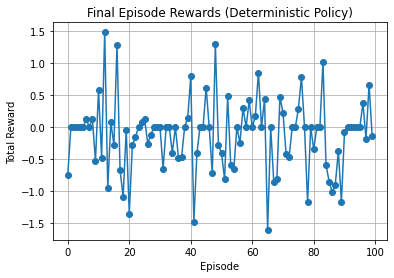

In [9]:
def evaluate_agent(env, model, n_episodes=5):
    """
    Runs n_episodes with a deterministic policy, returns a list of final rewards (floats).
    """
    rewards = []
    for ep in range(n_episodes):
        obs = env.reset()
        done = False
        ep_r = 0.0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            ep_r += reward[0]  # Because it's a DummyVecEnv (reward is array-like)
        rewards.append(ep_r)
    return rewards

# Evaluate the agent
episode_rewards = evaluate_agent(env, model, n_episodes=100)
print("Episode Rewards:", episode_rewards)

# Calculate % of rewards > 0
num_positive = sum(r > 0 for r in episode_rewards)
pct_positive = 100.0 * num_positive / len(episode_rewards)
print(f"Percentage of episodes with reward > 0: {pct_positive:.2f}%")

# Plot them
plt.figure()
plt.plot(episode_rewards, marker='o')
plt.title("Final Episode Rewards (Deterministic Policy)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()


Episode Rewards: [-0.01845484972000122, 0.0, 0.0, 0.044328153133392334, -2.039456009864807, 0.0, 0.0, -2.2903180718421936, 0.0, 0.0]


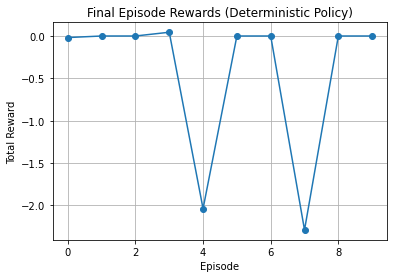

In [19]:
episode_rewards = evaluate_agent(env, model, n_episodes=10)
print("Episode Rewards:", episode_rewards)

# Plot them
plt.figure()
plt.plot(episode_rewards, marker='o')
plt.title("Final Episode Rewards (Deterministic Policy)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

In [10]:
def evaluate_agent_stepwise(env, model, n_episodes=1):
    """
    Returns a list (one element per episode), where each element is
    a list of the cumulative reward at each step of that episode.
    """
    stepwise_cum_rewards = []
    
    for ep in range(n_episodes):
        obs = env.reset()
        done = False
        ep_cum = 0.0
        ep_cum_list = []
        
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            
            # immediate reward is reward[0] because of DummyVecEnv
            immediate_r = reward[0]
            print(f"Step {len(ep_cum_list)}: immediate_r={immediate_r:.4f}")
            ep_cum += immediate_r
            ep_cum_list.append(ep_cum)
        
        stepwise_cum_rewards.append(ep_cum_list)
    
    return stepwise_cum_rewards


In [26]:
step_count = 0
obs = env.reset()
done = False
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    step_count += 1
print("Episode had", step_count, "steps")


Episode had 5000 steps


Step 0: immediate_r=-0.0063
Step 1: immediate_r=-0.0010
Step 2: immediate_r=0.0056
Step 3: immediate_r=-0.0021
Step 4: immediate_r=-0.0105
Step 5: immediate_r=-0.0062
Step 6: immediate_r=0.0024
Step 7: immediate_r=0.0035
Step 8: immediate_r=0.0060
Step 9: immediate_r=-0.0167
Step 10: immediate_r=0.0092
Step 11: immediate_r=-0.0049
Step 12: immediate_r=-0.0051
Step 13: immediate_r=0.0009
Step 14: immediate_r=-0.0120
Step 15: immediate_r=0.0022
Step 16: immediate_r=-0.0150
Step 17: immediate_r=-0.0102
Step 18: immediate_r=0.0242
Step 19: immediate_r=-0.0112
Step 20: immediate_r=0.0038
Step 21: immediate_r=0.0015
Step 22: immediate_r=0.0068
Step 23: immediate_r=-0.0053
Step 24: immediate_r=-0.0110
Step 25: immediate_r=0.0070
Step 26: immediate_r=0.0090
Step 27: immediate_r=-0.0245
Step 28: immediate_r=0.0038
Step 29: immediate_r=0.0003
Step 30: immediate_r=-0.0005
Step 31: immediate_r=-0.0039
Step 32: immediate_r=0.0130
Step 33: immediate_r=-0.0151
Step 34: immediate_r=-0.0109
Step 35: im

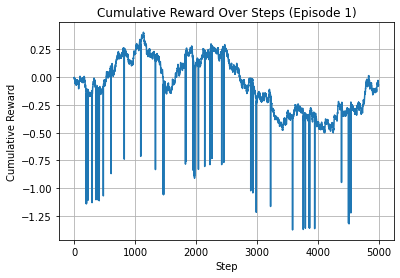

In [17]:
cumulative_rewards_per_episode = evaluate_agent_stepwise(env, model, n_episodes=1)
episode_cum = cumulative_rewards_per_episode[0]  # The first episode's list of stepwise cum rewards

import matplotlib.pyplot as plt

plt.figure()
plt.plot(episode_cum)
plt.title("Cumulative Reward Over Steps (Episode 1)")
plt.xlabel("Step")
plt.ylabel("Cumulative Reward")
plt.grid(True)
plt.show()


Step 0: immediate_r=-0.0024
Step 1: immediate_r=0.0014
Step 2: immediate_r=-0.0047
Step 3: immediate_r=0.0020
Step 4: immediate_r=-0.0044
Step 5: immediate_r=0.0020
Step 6: immediate_r=-0.0048
Step 7: immediate_r=-0.0025
Step 8: immediate_r=0.0081
Step 9: immediate_r=-0.0064
Step 10: immediate_r=-0.0066
Step 11: immediate_r=-0.0017
Step 12: immediate_r=-0.0028
Step 13: immediate_r=-0.0002
Step 14: immediate_r=0.0061
Step 15: immediate_r=-0.0010
Step 16: immediate_r=-0.0175
Step 17: immediate_r=0.0120
Step 18: immediate_r=-0.0157
Step 19: immediate_r=-0.0003
Step 20: immediate_r=0.0130
Step 21: immediate_r=0.0050
Step 22: immediate_r=0.0080
Step 23: immediate_r=0.0124
Step 24: immediate_r=0.0147
Step 25: immediate_r=0.0088
Step 26: immediate_r=-0.0098
Step 27: immediate_r=-0.0061
Step 28: immediate_r=0.0038
Step 29: immediate_r=-0.0017
Step 30: immediate_r=0.0054
Step 31: immediate_r=-0.0009
Step 32: immediate_r=0.0014
Step 33: immediate_r=0.0011
Step 34: immediate_r=0.0045
Step 35: imm

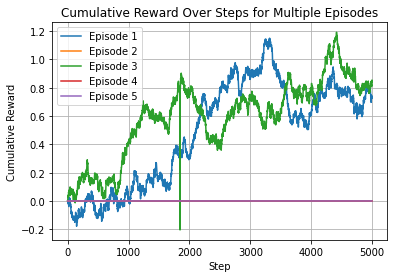

In [29]:
import matplotlib.pyplot as plt

# Number of episodes to evaluate
n_episodes = 5

# Evaluate agent stepwise for multiple episodes
cumulative_rewards_per_episode = evaluate_agent_stepwise(env, model, n_episodes=n_episodes)

# Plot cumulative rewards for each episode
plt.figure()

for i, episode_cum in enumerate(cumulative_rewards_per_episode):
    plt.plot(episode_cum, label=f"Episode {i+1}")

plt.title("Cumulative Reward Over Steps for Multiple Episodes")
plt.xlabel("Step")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.grid(True)
plt.show()
